In [1]:
%load_ext autoreload
%autoreload 1
import scipy.io as io
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import numpy as np
from itertools import product
import os
from model.ExtendedTSSRP import ExtendedTSSRP
from model.TSSRP import TSSRP
from model.MSSRP import MSSRP
from model.adaptCUSUM import AdaptCUSUM
from spc import spc
import time
import pickle

# Load Data 

In [2]:
data = io.loadmat('data/tonnage.mat')
X = data['X']
y = data['y'][:,0]

# Preprocessing

In [3]:
vx = np.moveaxis(X,0,1).reshape(-1,582).T # Reshape the data
y[y==5]=2 # Relabel the label '5' to '2' 

data_normal = vx[y==0] # Select label 0 as normal sample
nNormalSample = vx[y==0].shape[0]
p = vx.shape[1] # Dimensionality of the data
nFailureMode = np.max(y)-1 # Falure Mode Number
nAbnormalSample = vx[y==1].shape[0] # sample number
data_abnormal = np.zeros((nFailureMode,nAbnormalSample,p)) # 5 failure modes, 69 samples, with 4804 dimension
for i in range(1,nFailureMode+1):
    data_abnormal[i-1] = vx[y==i]

In [4]:
data_normal_diff = np.diff(data_normal,n=1,axis=0)
data_normal_diff_mean = np.mean(data_normal_diff,axis=0)
data_normal_diff_std = np.std(data_normal_diff,axis=0)
data_normal_diff = data_normal_diff - data_normal_diff_mean[np.newaxis,:]
data_normal_diff = data_normal_diff/data_normal_diff_std[np.newaxis,:]

data_abnormal_diff = np.diff(data_abnormal,n=1,axis=1)
data_abnormal_diff = data_abnormal_diff - data_normal_diff_mean[np.newaxis,np.newaxis,:]
data_abnormal_diff = data_abnormal_diff/data_normal_diff_std[np.newaxis,:]

In [5]:
data_abnormal_mean = [[] for i in range(nFailureMode)]
data_abnormal_std = [[] for i in range(nFailureMode)]
M = np.zeros((nFailureMode,4804))
for i in range(nFailureMode):
    M[i] = np.mean(data_abnormal_diff[i],axis=0)
    M[i] = M[i] / np.sqrt(np.sum(M[i]**2))
M = M.T

In [6]:
normal_index = np.random.choice(nNormalSample-1, size=500, replace=True)
abormal_index = np.random.choice(nAbnormalSample-1, size=500, replace=True)

all_Simulated_data = [[] for i in range(nFailureMode)]
for i in range(nFailureMode):
#     all_Simulated_data[i] = np.concatenate((data_normal_diff[normal_index,:],data_abnormal_diff[i][abormal_index,:]))
    all_Simulated_data[i] = np.concatenate((data_normal_diff,data_abnormal_diff[i]))

# Create Model Instance

In [7]:
p = 4804 # Number of dimensions
c = 0.5 # Target meanshift is c * M
Ks = 2   #Select Top Ks control chart
T0 = 30
k = 3
nmodels = 3
M_tssrp = np.kron(np.eye(p),np.ones((1,1))) # Mean Failure Modes
nsensors = 800 # Number of selected sensors
experiment_log = {'c':c, 'Ks':Ks, 'statistics':[[] for i in range(nmodels)],
                  'sens_history':[[] for i in range(nmodels)],
                  'mode_history':[[] for i in range(nmodels)],
                  'seq_stats':[[] for i in range(nmodels)]}

model_all = [[] for i in range(nmodels)]
model_all[0] = ExtendedTSSRP(p, c, k,M,nsensors,Ks,L=-1,chart = 'srp',mode='T2')
model_all[1] = TSSRP(p, c, p,M_tssrp,nsensors,Ks,L=-1,chart='srp',mode='T2')
mumin = 1
model_all[2]= AdaptCUSUM(p, c, p, M, nsensors, nsensors, mumin = mumin,delta=0.0001)

failure_idx = 0
model_idx = 0
all_Simulated_data[failure_idx].shape

(373, 4804)

# Run Experiment

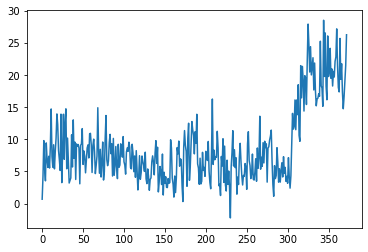

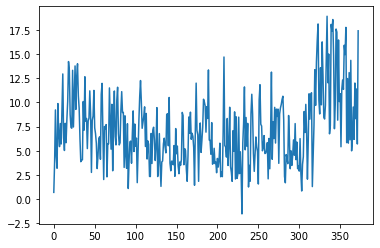

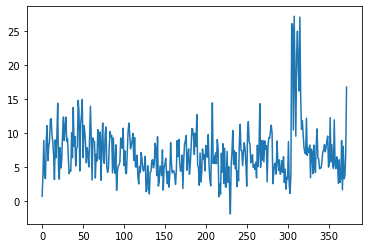

In [8]:
a = []
b = []
c = []
d = []
for failure_idx in range(3):
    sequential_statistis_topRsum, sensor_selection_history, failure_mode_history, i,sequential_statistics = model_all[0].compute_monitoring_statistics(all_Simulated_data[failure_idx],T0,-1)
    a.append(sequential_statistis_topRsum)
    b.append(failure_mode_history)
    c.append(sequential_statistics)
    d.append(sensor_selection_history)
    plt.figure()
    plt.plot(sequential_statistis_topRsum)

# Monitoring Statistics 

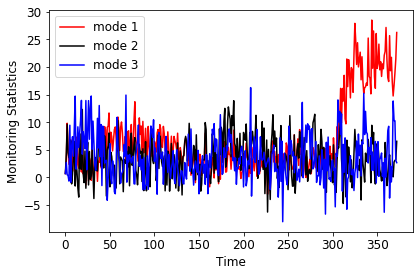

In [9]:
import matplotlib
font = {
        'weight' : 'regular',
        'size'   : 12}
matplotlib.rc('font', **font)
plt.plot(c[0][:,0],label='mode 1', color = 'r')
plt.plot(c[0][:,1],label='mode 2', color = 'k')
plt.plot(c[0][:,2],label='mode 3', color = 'b')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Monitoring Statistics')
plt.tight_layout()

# Sampling Pattern

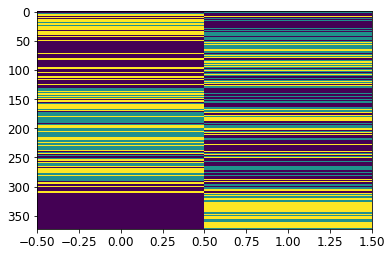

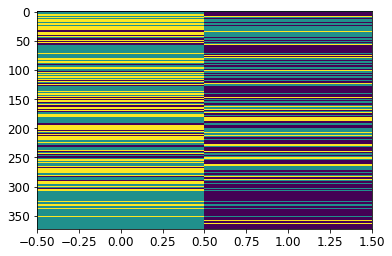

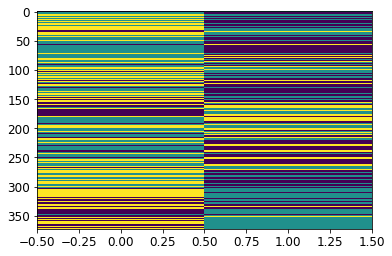

In [10]:
for failure_idx in range(3):
    plt.figure()
    plt.imshow(b[failure_idx],aspect='auto')